## 全连接

In [7]:
#@title vae全链接训练

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

# 定义VAE模型
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()

        # 编码器网络
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        # 均值和对数方差
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # 解码器网络
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# 计算VAE的损失函数
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# 参数设置
input_dim = 28 * 28  # MNIST数据集的输入维度
hidden_dim = 400
latent_dim = 20
lr = 1e-3
batch_size = 128
epochs = 10

# 检查是否可以使用GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 加载MNIST数据集
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# 初始化模型、优化器
model = VAE(input_dim, hidden_dim, latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

# 训练VAE
model.train()
for epoch in range(epochs):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.view(-1, input_dim).to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f'Epoch {epoch+1}, Loss: {train_loss/len(train_loader.dataset):.4f}')

# 生成样本
model.eval()
with torch.no_grad():
    z = torch.randn(64, latent_dim).to(device)
    sample = model.decode(z).cpu()
    sample = sample.view(64, 1, 28, 28)


Using device: cuda
Epoch 1, Loss: 177.5885
Epoch 2, Loss: 128.6674
Epoch 3, Loss: 117.5387
Epoch 4, Loss: 113.0109
Epoch 5, Loss: 110.0564
Epoch 6, Loss: 108.1593
Epoch 7, Loss: 106.7512
Epoch 8, Loss: 105.7202
Epoch 9, Loss: 104.7970
Epoch 10, Loss: 104.1266


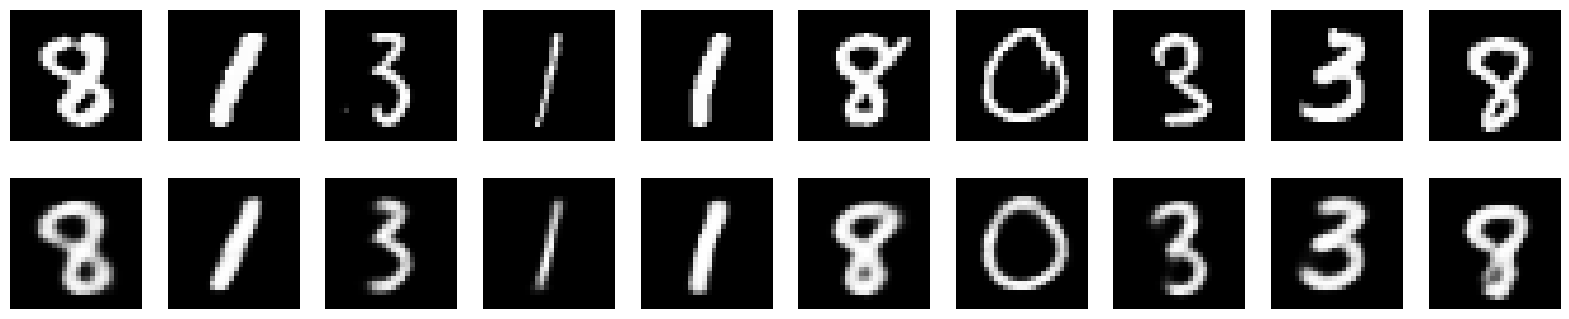

In [8]:
#@title 验证模型

import matplotlib.pyplot as plt

def show_images(original, reconstructed, num_images=10):
    plt.figure(figsize=(20, 4))
    for i in range(num_images):
        # 展示原始图像
        ax = plt.subplot(2, num_images, i + 1)
        plt.imshow(original[i].reshape(28, 28), cmap="gray")
        ax.axis('off')

        # 展示重构图像
        ax = plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(reconstructed[i].reshape(28, 28), cmap="gray")
        ax.axis('off')

    plt.show()

# 从测试集加载数据
test_loader = DataLoader(datasets.MNIST('./data', train=False, transform=transforms.ToTensor()), batch_size=batch_size, shuffle=True)

# 验证重构效果
model.eval()
with torch.no_grad():
    for data, _ in test_loader:
        data = data.view(-1, input_dim).to(device)
        recon_data, _, _ = model(data)
        show_images(data.cpu(), recon_data.cpu())
        break

## 卷积


In [ ]:
#@title vae卷积训练


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

# 参数设置
input_dim = 28 * 28  # MNIST数据集的输入维度
hidden_dim = 400
latent_dim = 20
lr = 1e-3
batch_size = 128
epochs = 10

# 检查是否可以使用GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 定义卷积VAE模型
class ConvVAE(nn.Module):
    def __init__(self, latent_dim):
        super(ConvVAE, self).__init__()

        # 编码器网络
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  # [batch, 1, 28, 28] -> [batch, 32, 14, 14]
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # [batch, 32, 14, 14] -> [batch, 64, 7, 7]
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # [batch, 64, 7, 7] -> [batch, 128, 4, 4]
            nn.ReLU(),
            nn.Flatten()  # [batch, 128, 4, 4] -> [batch, 128*4*4]
        )

        self.fc_mu = nn.Linear(128 * 3 * 3, latent_dim)
        self.fc_logvar = nn.Linear(128 * 3 * 3, latent_dim)

        # 解码器网络
        self.decoder_input = nn.Linear(latent_dim, 128 * 3 * 3)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(72, 64, kernel_size=3, stride=2, padding=1),  # [batch, 128, 4, 4] -> [batch, 64, 8, 8]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # [batch, 64, 8, 8] -> [batch, 32, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),  # [batch, 32, 16, 16] -> [batch, 1, 28, 28]
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        # print("x shape:", x.shape)
        # print("h shape:", h.shape)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.decoder_input(z)
        # print("hh shape:", h.shape)
        h = h.view(128, -1, 4, 4)  # 重新reshape为解码器的输入维度
        # print("hhh shape:", h.shape)
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        tmp = self.decode(z)
        # print("z shape:", z.shape)
        # print("tmp shape:", tmp.shape)
        return self.decode(z), mu, logvar

# 计算VAE的损失函数
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# 参数设置
latent_dim = 20
lr = 1e-3
batch_size = 128
epochs = 10

# 加载MNIST数据集
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# 初始化模型、优化器
model = ConvVAE(latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

# 训练VAE
model.train()
for epoch in range(epochs):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        if (data.shape[0] < 128 ):
          continue
        recon_batch, mu, logvar = model(data.to(device))
        loss = loss_function(recon_batch, data.to(device), mu, logvar)
        loss.backward()
        train_loss += loss.item()
        # print("recon_batch: ", recon_batch.shape)

        # if (recon_batch.shape[1] < 128 ):
        #   continue
        optimizer.step()

    print(f'Epoch {epoch+1}, Loss: {train_loss/len(train_loader.dataset):.4f}')

# # 生成样本
# model.eval()
# with torch.no_grad():
#     z = torch.randn(64, latent_dim).to(device)
#     sample = model.decode(z).to(device).cpu()
#     sample = sample.view(64, 1, 28, 28)


In [ ]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

def show_images(original, reconstructed, num_images=10):
    plt.figure(figsize=(20, 4))
    for i in range(num_images):
        # 展示原始图像
        ax = plt.subplot(2, num_images, i + 1)
        plt.imshow(original[i].reshape(28, 28), cmap="gray")
        ax.axis('off')

        # 展示重构图像
        ax = plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(reconstructed[i].reshape(28, 28), cmap="gray")
        ax.axis('off')

    plt.show()

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 加载MNIST测试集数据
test_loader = DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)

# 验证重构效果
model.eval()
model.to(device)  # 确保模型在正确的设备上
with torch.no_grad():
    for data, _ in test_loader:
        data = data.to(device)  # 不需要展平数据
        recon_data, _, _ = model(data)
        show_images(data.cpu(), recon_data.cpu())
        break  # 仅显示一个批次的数据
